In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import pickle
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [4]:
# Load the dataset, drop some unneccessary column to resize
data = pd.read_csv("final_merged_data.csv")
data = data.loc[:, ~data.columns.str.contains("quality_indicator")]

In [5]:
# Check raw data set provided
pd.set_option('display.max_columns', None)
data.describe()



,station_id,num_bikes_available,num_docks_available,lat,lon,capacity,stno,year,month,day,hour,minute,max_air_temperature_celsius,min_air_temperature_celsius,air_temperature_std_deviation,max_grass_temperature_celsius,min_grass_temperature_celsius,grass_temperature_std_deviation,max_soil_temperature_5cm_celsius,min_soil_temperature_5cm_celsius,soil_temperature_std_deviation_5cm,max_soil_temperature_10cm_celsius,min_soil_temperature_10cm_celsius,soil_temperature_std_deviation_10cm,max_soil_temperature_20cm_celsius,min_soil_temperature_20cm_celsius,soil_temperature_std_deviation_20cm,max_earth_temperature_30cm_celsius,min_earth_temperature_30cm_celsius,earth_temperature_std_deviation_30cm,max_earth_temperature_50cm_celsius,min_earth_temperature_50cm_celsius,earth_temperature_std_deviation_50cm,max_earth_temperature_100cm_celsius,min_earth_temperature_100cm_celsius,earth_temperature_std_deviation_100cm,max_relative_humidity_percent,min_relative_humidity_percent,relative_humidity_std_deviation,max_barometric_pressure_hpa,min_barometric_pressure_hpa,barometric_pressure_std_deviation
count,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.0,298946.0,298946.0,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000
mean,57.967138,12.204733,19.335198,53.345521,-6.263842,31.979003,175.0,2024.0,12.0,15.717484,11.522128,24.878941,7.855169,7.716685,0.040432,6.564362,6.229473,0.100257,7.047128,7.007714,0.009456,7.159650,7.125825,0.007945,7.258614,7.225430,0.007645,7.390959,7.358199,0.007551,7.995048,7.964415,0.007055,9.437616,9.406651,0.007106,85.021124,83.548719,0.377589,1014.855870,1014.689671,0.045488
std,33.958176,9.761814,11.001506,0.007538,0.017855,7.459101,0.0,0.0,0.0,8.896832,6.280459,17.112726,3.123094,3.136997,0.038731,3.901582,3.946463,0.105303,1.508867,1.509558,0.003023,1.232544,1.233239,0.001651,0.975946,0.976103,0.001110,0.876321,0.876168,0.001084,0.537950,0.537683,0.000938,0.280474,0.280232,0.000920,7.867297,8.160979,0.232676,11.823993,11.894264,0.038661
min,1.000000,0.000000,0.000000,53.330090,-6.310015,16.000000,175.0,2024.0,12.0,1.000000,0.000000,0.000000,-3.448000,-3.521000,0.003000,-8.950000,-9.050000,0.006000,3.231000,3.195000,0.004000,4.578000,4.545000,0.004000,5.285000,5.251000,0.005000,5.624000,5.593000,0.004000,6.903000,6.875000,0.004000,9.030000,9.000000,0.004000,56.700000,52.970000,0.072000,975.060000,975.010000,0.004000
25%,28.000000,4.000000,11.000000,53.339764,-6.275071,29.000000,175.0,2024.0,12.0,8.000000,7.000000,10.000000,5.736000,5.615000,0.017000,4.282000,4.014000,0.032000,5.899000,5.849000,0.007000,6.196000,6.166000,0.007000,6.422000,6.390000,0.007000,6.655000,6.622000,0.007000,7.533000,7.503000,0.006000,9.250000,9.220000,0.006000,80.600000,78.910000,0.230000,1006.010000,1005.770000,0.022000
50%,57.000000,11.000000,19.000000,53.345203,-6.262501,30.000000,175.0,2024.0,12.0,16.000000,12.000000,20.000000,7.955000,7.790000,0.030000,7.140000,6.773000,0.066000,7.108000,7.069000,0.009000,7.140000,7.108000,0.008000,7.200000,7.166000,0.008000,7.344000,7.315000,0.008000,7.969000,7.939000,0.007000,9.340000,9.310000,0.007000,86.000000,84.700000,0.314000,1017.210000,1017.060000,0.034000
75%,88.000000,19.000000,28.000000,53.350292,-6.250900,40.000000,175.0,2024.0,12.0,23.000000,16.000000,40.000000,10.190000,10.070000,0.052000,9.460000,9.150000,0.130000,8.350000,8.320000,0.011000,8.260000,8.230000,0.009000,8.140000,8.110000,0.008000,8.180000,8.150000,0.008000,8.490000,8.460000,0.008000,9.650000,9.620000,0.008000,90.300000,89.000000,0.450000,1022.660000,1022.570000,0.057000
max,117.0

In [7]:
#PREPARE TRAINIGNG DATA

# Handle missing values (drop rows with NaN in lagged features)
data.dropna(inplace=True)
# Calculate avg for weather:
data['temperature'] = (data['max_air_temperature_celsius'] + data['min_air_temperature_celsius']) / 2
data['humidity'] = (data['max_relative_humidity_percent'] + data['min_relative_humidity_percent']) / 2
data['pressure'] = (data['max_barometric_pressure_hpa'] + data['min_barometric_pressure_hpa']) / 2
#Calculate day of week:
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
data['day_of_week'] = data['date'].dt.weekday
data = data[['station_id','temperature', 'humidity', 'pressure', 'hour', 'day_of_week', 'num_bikes_available']]
# Save the cleaned version
data.to_csv("final_data_for_ml.csv", index=False)


In [8]:
data = pd.read_csv("final_data_for_ml.csv")
data['station_id'] = data['station_id'].astype('category')
data.head()
data.describe()

,temperature,humidity,pressure,hour,day_of_week,num_bikes_available
count,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000
mean,7.785927,84.284922,1014.772770,11.522128,2.923478,12.204733
std,3.129450,8.004812,11.859002,6.280459,2.060851,9.761814
min,-3.484500,55.070000,975.035000,0.000000,0.000000,0.000000
25%,5.676500,79.770000,1005.915000,7.000000,1.000000,4.000000
50%,7.872000,85.350000,1017.125000,12.000000,3.000000,11.000000
75%,10.125000,89.600000,1022.615000,16.000000,5.000000,19.000000
max,14.630000,98.850000,1035.775000,23.000000,6.000000,40.000000


In [ ]:
## To define features: check interaction between station and hour by visualising
import matplotlib.pyplot as plt
for id in range(1,20):
    data_station= data[data["station_id"] == id]

    # Create a scatter plot of num_bikes_available vs hour
    print ("Station",id)
    plt.figure(figsize=(10, 6))
    plt.scatter(data_station["hour"], data_station["num_bikes_available"], alpha=0.6)
    plt.title("Number of Available Bikes vs Hour (Station ID =")
    plt.xlabel("Hour of Day")
    plt.ylabel("Number of Available Bikes")
    plt.show()

# Create new variable that could represent interaction term for station and hour
data['station_hour'] = data['station_id'].astype(str) + "_" + data['hour'].astype(str)

In [261]:
# Define features and target
features = ['temperature', 'humidity', 'pressure', 'station_hour', 'day_of_week', ]
target = 'num_bikes_available'

X = data[features]
y = data[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [262]:
#TRAINING 

# Define preprocessing for categorical column
categorical_features = ['station_hour']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features)  # Using one-hot encoder to create dummy variable for categorical
    ],
    remainder='passthrough' 
)

# Create pipeline that include preprocessing and model (linear regression)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
# Fit the linear regression model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Access the trained model from inside the pipeline
regressor = pipeline.named_steps['regressor']

# Get the categorical that used one-hot encoder from the pipeline and generate their names
ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

# Define numerical features: 
numeric_features = ['temperature', 'humidity', 'pressure', 'day_of_week']

# Combine all feature names and show coeffients
all_feature_names = list(ohe_feature_names) + numeric_features
print("\nModel Coefficients:")
for feature, coef in zip(all_feature_names, regressor.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {regressor.intercept_}")


# Save the model to a .pkl file
model_filename = "bike_availability_model.pkl"
with open(model_filename, "wb") as file:
    pickle.dump(pipeline, file)

print(f"Model saved to {model_filename}")

Mean Absolute Error: 5.7820813192654565
R² Score: 0.43656667866089305

Model Coefficients:
station_hour_100_1: 7.979524423698878
station_hour_100_10: -2.4766717708103365
station_hour_100_11: -2.057448837942791
station_hour_100_12: -0.5583594624174255
station_hour_100_13: 0.22624423957851858
station_hour_100_14: -1.3414326548972666
station_hour_100_15: 5.411428332971959
station_hour_100_16: 8.601268050826256
station_hour_100_17: 8.999407407022927
station_hour_100_18: 9.225798184405798
station_hour_100_19: 9.518168464028125
station_hour_100_2: 8.734580770544774
station_hour_100_20: 8.439439888657786
station_hour_100_21: 9.679640084055023
station_hour_100_22: 9.682397938655424
station_hour_100_23: 7.8564500375953825
station_hour_100_3: 9.01531570411112
station_hour_100_4: 7.946817217205778
station_hour_100_5: 8.615830929370048
station_hour_100_6: 8.542277787935452
station_hour_100_7: 2.890586519104915
station_hour_100_8: -1.488335400606371
station_hour_100_9: -1.3319090125018056
station_h

In [248]:
## TESTING

# Load the saved model
with open("bike_availability_model.pkl", "rb") as file:
    model = pickle.load(file)

# TEST 1: testing predicted value generated through flask app vs predicted value from running model in notebook

# Define input data for prediction 

new_data = pd.DataFrame({
    'station_id': [5], # Testing user input on app
    'temperature': [9.55], #Actual openweather values of input date and time
    'humidity': [88], #Actual openweather values of input date and time
    'pressure': [1022], #Actual openweather values of input date and time
    'hour': [16], # Testing user input on app
    'day_of_week': [1]  # Testing user input on app
})
new_data['station_hour'] = new_data['station_id'].astype(str) + "_" + new_data['hour_bin'].astype(str)
new_data=new_data[['station_id','temperature', 'humidity', 'pressure', 'hour', 'day_of_week', 'station_hour']]
# Make prediction

prediction = model.predict(new_data)
# Output prediction
print(f"Predicted number of available bikes: {round(prediction[0])}")



Predicted number of available bikes: 21


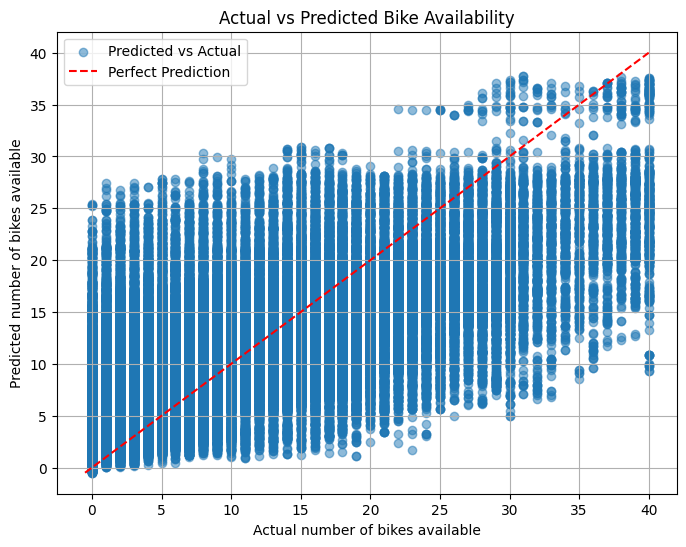

In [254]:
#TEST2 plotting actual vs predicted values
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs Actual')

# Plot perfect prediction line (y = x)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel("Actual number of bikes available")
plt.ylabel("Predicted number of bikes available")
plt.title("Actual vs Predicted Bike Availability")
plt.legend()
plt.grid(True)
plt.show()
